# Imports

In [ ]:
%pip install tensorflow==2.0.0
%pip install keras==2.3.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import nltk
import re
import numpy as np
from matplotlib import pyplot as plt
import os
from tqdm import tqdm
import itertools
import pandas as pd
from scipy import sparse
from zipfile import ZipFile


# Deep learning: 
from keras.models import Input, Model
from keras.layers import Dense

Using TensorFlow backend.


In [ ]:

import nltk
nltk.download('reuters')
from nltk.corpus import reuters


[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


In [ ]:
def get_corpus_text(cat):
    '''
    return raw text of reuters corpus
    '''
    return [" ".join(reuters.words(fid)) for fid in reuters.fileids(categories=cat)] 

In [ ]:
crude = get_corpus_text(['crude'])
crude_top_100 = crude[:100]

In [ ]:
newses = np.array(crude_top_100)
newses.shape

(100,)

In [ ]:
newses[0]

"JAPAN TO REVISE LONG - TERM ENERGY DEMAND DOWNWARDS The Ministry of International Trade and Industry ( MITI ) will revise its long - term energy supply / demand outlook by August to meet a forecast downtrend in Japanese energy demand , ministry officials said . MITI is expected to lower the projection for primary energy supplies in the year 2000 to 550 mln kilolitres ( kl ) from 600 mln , they said . The decision follows the emergence of structural changes in Japanese industry following the rise in the value of the yen and a decline in domestic electric power demand . MITI is planning to work out a revised energy supply / demand outlook through deliberations of committee meetings of the Agency of Natural Resources and Energy , the officials said . They said MITI will also review the breakdown of energy supply sources , including oil , nuclear , coal and natural gas . Nuclear energy provided the bulk of Japan ' s electric power in the fiscal year ended March 31 , supplying an estimated

# Utility

In [ ]:
def create_unique_word_dict(text:list) -> dict:
    """
    A method that creates a dictionary where the keys are unique words
    and key values are indices
    """
    # Getting all the unique words from our text and sorting them alphabetically
    words = list(set(text))
    words.sort()

    # Creating the dictionary for the unique words
    unique_word_dict = {}
    for i, word in enumerate(words):
        unique_word_dict.update({
            word: i
        })

    return unique_word_dict
  
def text_preprocessing(
    text:list,
    punctuations = r'''!()-[]{};:'"\,<>./?@#$%^&*_“~''',
    stop_words=['and', 'a', 'is', 'the', 'in', 'be', 'will']
    )->list:
    """
    A method to preproces text
    """
    for x in text.lower(): 
        if x in punctuations: 
            text = text.replace(x, "")

    # Removing words that have numbers in them
    text = re.sub(r'\w*\d\w*', '', text)

    # Removing digits
    text = re.sub(r'[0-9]+', '', text)

    # Cleaning the whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Setting every word to lower
    text = text.lower()

    # Converting all our text to a list 
    text = text.split(' ')

    # Droping empty strings
    text = [x for x in text if x!='']

    # Droping stop words
    text = [x for x in text if x not in stop_words]

    return text

# Functions to find the most similar word 
def euclidean(vec1:np.array, vec2:np.array) -> float:
    """
    A function to calculate the euclidean distance between two vectors
    """
    return np.sqrt(np.sum((vec1 - vec2)**2))

def find_similar(word:str, embedding_dict:dict, top_n=10)->list:
    """
    A method to find the most similar word based on the learnt embeddings
    """
    dist_dict = {}
    word_vector = embedding_dict.get(word, [])
    if len(word_vector) > 0:
        for key, value in embedding_dict.items():
            if key!=word:
                dist = euclidean(word_vector, value)
                dist_dict.update({
                    key: dist
                })

        return sorted(dist_dict.items(), key=lambda x: x[1])[0:top_n]      

# Word embeding

In [ ]:
# Defining the window for context
window = 2

# Creating a placeholder for the scanning of the word list
word_lists = []
all_text = []

In [ ]:
for news in newses:
  #clean news
  text = text_preprocessing(text=news)
  all_text += text

  # Creating a context dictionary
  for i, word in enumerate(text):
      for w in range(window):
          # Getting the context that is ahead by *window* words
          if i + 1 + w < len(text): 
              word_lists.append([word] + [text[(i + 1 + w)]])
          # Getting the context that is behind by *window* words    
          if i - w - 1 >= 0:
              word_lists.append([word] + [text[(i - w - 1)]])

In [ ]:
all_text[:10]

['japan',
 'to',
 'revise',
 'long',
 'term',
 'energy',
 'demand',
 'downwards',
 'ministry',
 'of']

In [ ]:
word_lists[:10]

[['japan', 'to'],
 ['japan', 'revise'],
 ['to', 'revise'],
 ['to', 'japan'],
 ['to', 'long'],
 ['revise', 'long'],
 ['revise', 'to'],
 ['revise', 'term'],
 ['revise', 'japan'],
 ['long', 'term']]

In [ ]:
unique_word_dict = create_unique_word_dict(all_text)
# Defining the number of features (unique words)
n_words = len(unique_word_dict)

# Getting all the unique words 
words = list(unique_word_dict.keys())

In [ ]:
# Creating the X and Y matrices using one hot encoding
X = []
Y = []

for i, word_list in tqdm(enumerate(word_lists)):
    # Getting the indices
    main_word_index = unique_word_dict.get(word_list[0])
    context_word_index = unique_word_dict.get(word_list[1])

    # Creating the placeholders   
    X_row = np.zeros(n_words)
    Y_row = np.zeros(n_words)

    # One hot encoding the main word
    X_row[main_word_index] = 1

    # One hot encoding the Y matrix words 
    Y_row[context_word_index] = 1

    # Appending to the main matrices
    X.append(X_row)
    Y.append(Y_row)

# Converting the matrices into a sparse format because the vast majority of the data are 0s
X = sparse.csr_matrix(X)
Y = sparse.csr_matrix(Y)

56416it [00:02, 25529.77it/s]


In [ ]:
# Defining the size of the embedding
embed_size = 2

# Defining the neural network
inp = Input(shape=(X.shape[1],))
x = Dense(units=embed_size, activation='linear')(inp)
x = Dense(units=Y.shape[1], activation='softmax')(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

print(model.summary())


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2728)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 5458      
_________________________________________________________________
dense_2 (Dense)              (None, 2728)              8184      
Total params: 13,642
Trainable params: 13,642
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:

# Optimizing the network weights
model.fit(x=X, y=Y, batch_size=256,epochs=10)

Epoch 1/10
56416/56416 [==============================] - 8s 137us/step - loss: 7.7902
Epoch 2/10
56416/56416 [==============================] - 7s 127us/step - loss: 7.3407
Epoch 3/10
56416/56416 [==============================] - 7s 129us/step - loss: 6.8770
Epoch 4/10
56416/56416 [==============================] - 7s 131us/step - loss: 6.6743
Epoch 5/10
56416/56416 [==============================] - 7s 128us/step - loss: 6.6292
Epoch 6/10
56416/56416 [==============================] - 7s 129us/step - loss: 6.6155
Epoch 7/10
56416/56416 [==============================] - 7s 129us/step - loss: 6.6078
Epoch 8/10
56416/56416 [==============================] - 7s 133us/step - loss: 6.6026
Epoch 9/10
56416/56416 [==============================] - 7s 131us/step - loss: 6.5990
Epoch 10/10
56416/56416 [==============================] - 7s 132us/step - loss: 6.5959


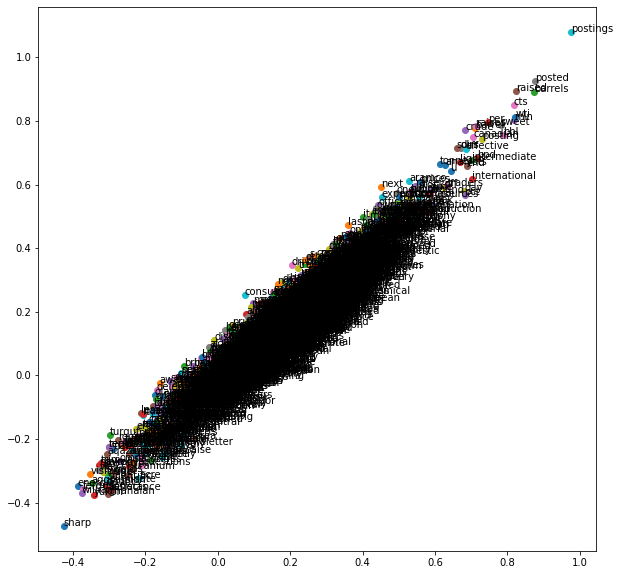

In [ ]:
# The input layer 
weights = model.get_weights()[0]

# Creating a dictionary to store the embeddings in. The key is a unique word and 
# the value is the numeric vector
embedding_dict = {}
for word in words: 
    embedding_dict.update({
        word: weights[unique_word_dict.get(word)]
        })

# Ploting the embeddings
plt.figure(figsize=(10, 10))
for word in list(unique_word_dict.keys()):
    coord = embedding_dict.get(word)
    plt.scatter(coord[0], coord[1])
    plt.annotate(word, (coord[0], coord[1]))    

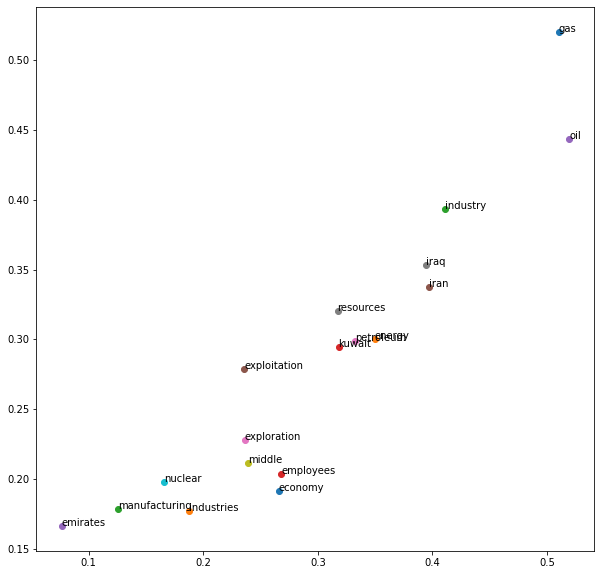

In [ ]:

question_words = [
    'gas', 'energy', 'industry', 'kuwait', 'oil', 'iran', 'petroleum', 'iraq',
'middle', 'nuclear', 'economy', 'industries', 'manufacturing', 'employees',
'emirates', 'exploitation', 'exploration', 'resources'
]
# Ploting the embeddings
plt.figure(figsize=(10, 10))
for word in question_words:
    coord = embedding_dict.get(word)

    plt.scatter(coord[0], coord[1])
    plt.annotate(word, (coord[0], coord[1]))


## Q3

In [ ]:
import keras
import cv2
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from keras.models import Sequential
from keras import layers


from sklearn.utils import shuffle

In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [ ]:
(x ,y) = shuffle(x_train, y_train, random_state=12)

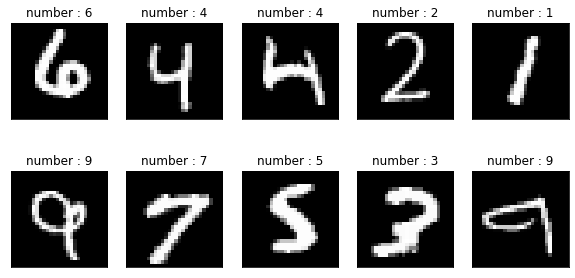

In [ ]:
# show data sets
row = 2
column = 5
classes = np.unique(y)

plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(row, column, i + 1)
    plt.imshow(x[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.title('number : {}'.format(y[i]))
plt.show()



In [ ]:
print('x_train shape : {}'.format(x.shape))
print('y_train shape : {}'.format(y.shape))
print('x_test shape : {}'.format(x_test.shape))
print('y_test shape : {}'.format(y_test.shape))

x_train shape : (60000, 28, 28)
y_train shape : (60000,)
x_test shape : (10000, 28, 28)
y_test shape : (10000,)


In [ ]:
def reshape(a):
  x,y,z = a.shape
  return a.reshape(x,y,z,1)

In [ ]:
  x = x / 255.0
  x_test = x_test / 255.0

In [ ]:
  x_train = reshape(x)
  x_test = reshape(x_test)
  print(f'x_train shape: {x.shape} x_test shape: {x_test.shape}')

x_train shape: (60000, 28, 28) x_test shape: (10000, 28, 28, 1)


In [ ]:
y_train = to_categorical(y)
y_test = to_categorical(y_test)

In [ ]:
print('x_train shape : {}  max : {}  min : {}'.format(x.shape, np.max(x), np.min(x)))
print('y_train shape : {}'.format(y_train.shape))
print('x_test shape : {}  max : {}  min : {}'.format(x_test.shape, np.max(x_test), np.min(x_test)))
print('y_test shape : {}'.format(y_test.shape))


x_train shape : (60000, 28, 28)  max : 1.0  min : 0.0
y_train shape : (60000, 10)
x_test shape : (10000, 28, 28, 1)  max : 1.0  min : 0.0
y_test shape : (10000, 10)


In [ ]:

def build_model(x):
    model = Sequential()
    model.add(layers.Input(shape=x.shape[1:]))
    model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size= (2, 2)))
    model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size= (2, 2)))
    model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D(pool_size= (2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(len(classes), activation='softmax'))

    return model

model = build_model(x_train)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 7, 7, 64)          36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 3, 64)         0

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])


In [ ]:
history = model.fit(x, y_train, batch_size=64, validation_split=0.1, epochs=15)

Epoch 1/15
844/844 [==============================] - 12s 9ms/step - loss: 0.1831 - accuracy: 0.9437 - val_loss: 0.0619 - val_accuracy: 0.9840
Epoch 2/15
844/844 [==============================] - 7s 8ms/step - loss: 0.0486 - accuracy: 0.9849 - val_loss: 0.0514 - val_accuracy: 0.9855
Epoch 3/15
844/844 [==============================] - 7s 8ms/step - loss: 0.0343 - accuracy: 0.9891 - val_loss: 0.0605 - val_accuracy: 0.9837
Epoch 4/15
844/844 [==============================] - 5s 6ms/step - loss: 0.0269 - accuracy: 0.9911 - val_loss: 0.0449 - val_accuracy: 0.9872
Epoch 5/15
844/844 [==============================] - 4s 5ms/step - loss: 0.0213 - accuracy: 0.9930 - val_loss: 0.0389 - val_accuracy: 0.9883
Epoch 6/15
844/844 [==============================] - 4s 5ms/step - loss: 0.0180 - accuracy: 0.9942 - val_loss: 0.0475 - val_accuracy: 0.9865
Epoch 7/15
844/844 [==============================] - 4s 5ms/step - loss: 0.0155 - accuracy: 0.9948 - val_loss: 0.0425 - val_accuracy: 0.9892
Epoch

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
def create_superimposed(img, heatmap, alpha=0.4):
    # Load the original image
    img = keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    return superimposed_img


In [ ]:
(_, _), (x, y) = keras.datasets.mnist.load_data()

In [ ]:
x = reshape(x)

In [ ]:
# Remove last layer's softmax
model.layers[-1].activation = None

predictions = model.predict(x=x)
predictions = np.argmax(predictions, axis=1)
y_test_no_categorical = np.argmax(y_test, axis=1)

x_true = x[predictions==y_test_no_categorical]
y_true = y[predictions==y_test_no_categorical]

imgs = []
for i in range(10):
  indices = np.argwhere(y_true==i).flatten()
  imgs.append(x_true[np.random.choice(indices, 10)])

number 0 ->


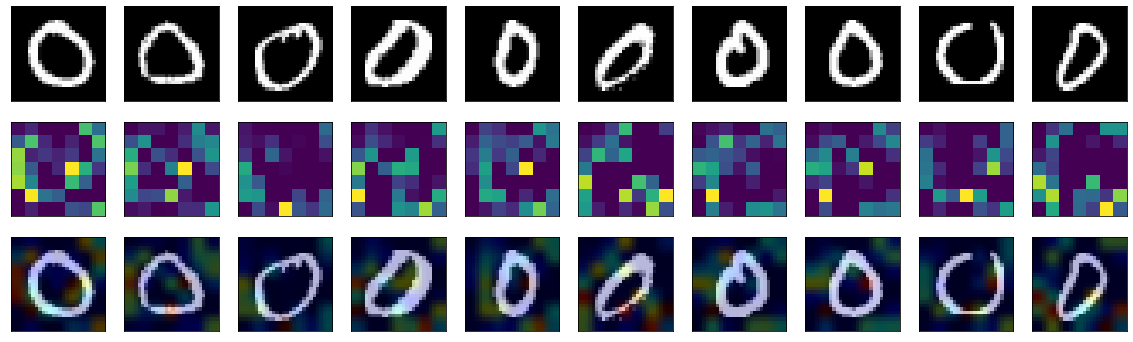

number 1 ->


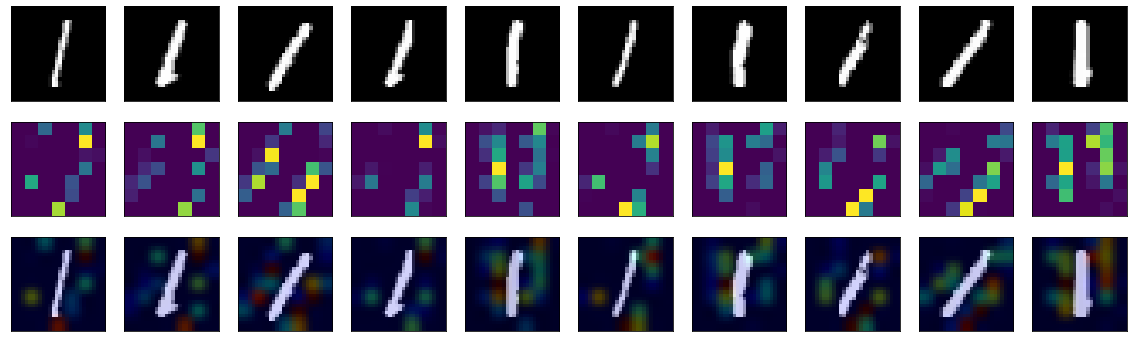

number 2 ->


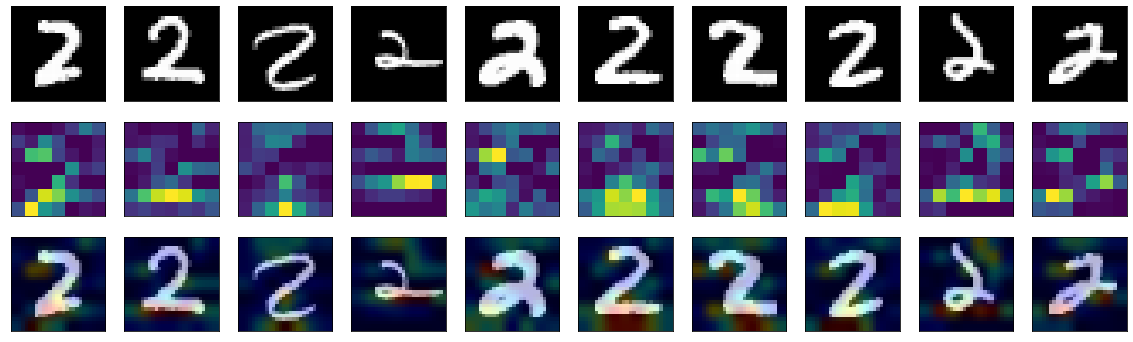

number 3 ->


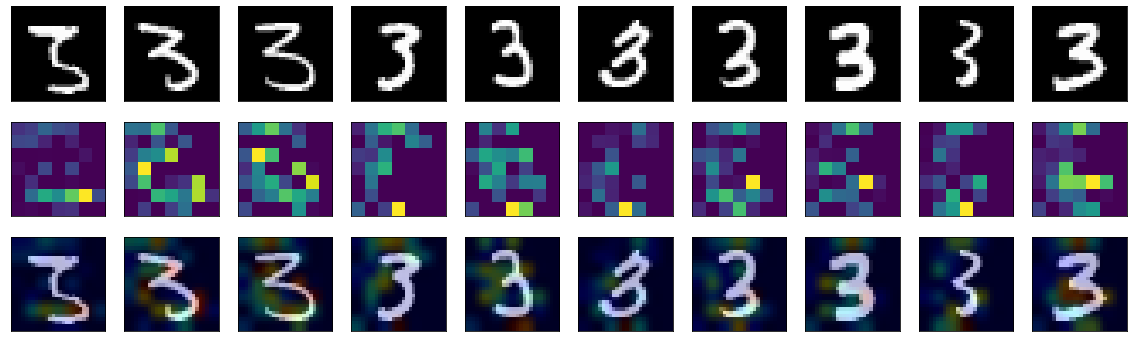

number 4 ->


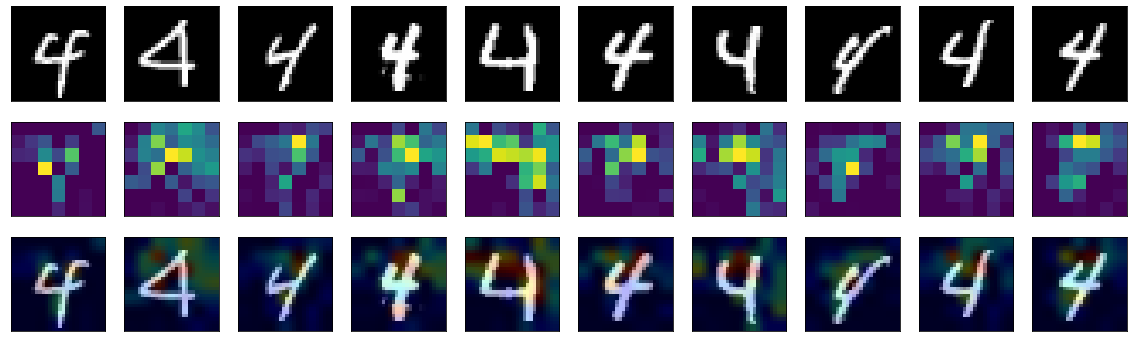

number 5 ->


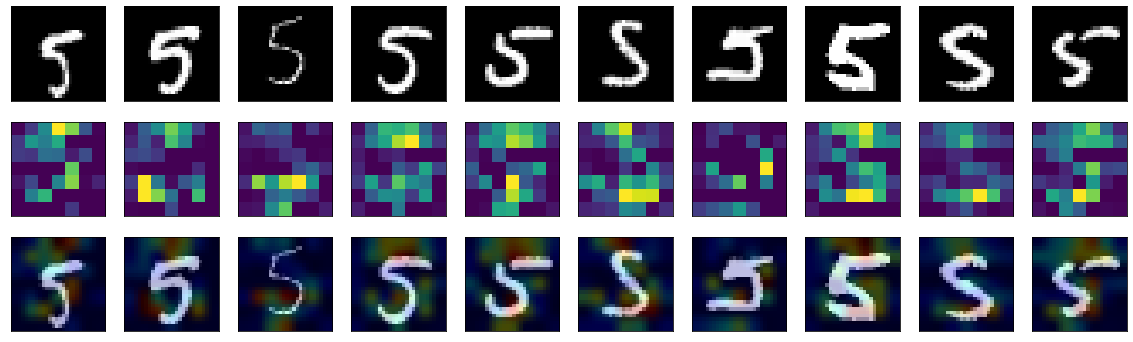

number 6 ->


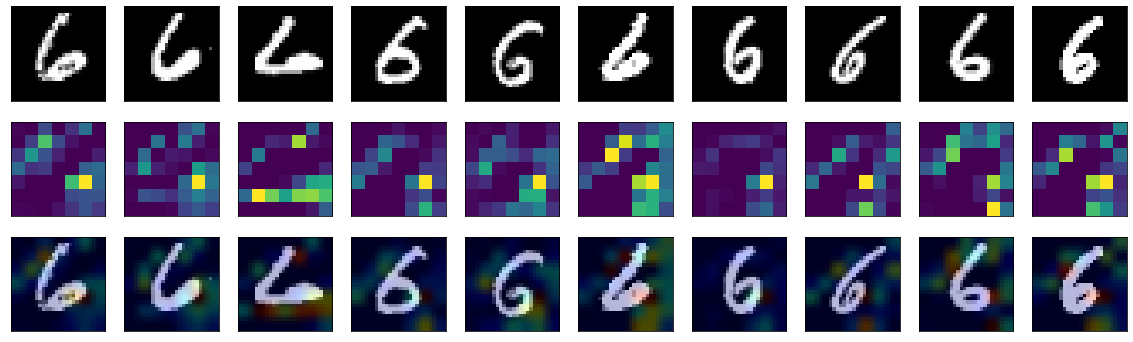

number 7 ->


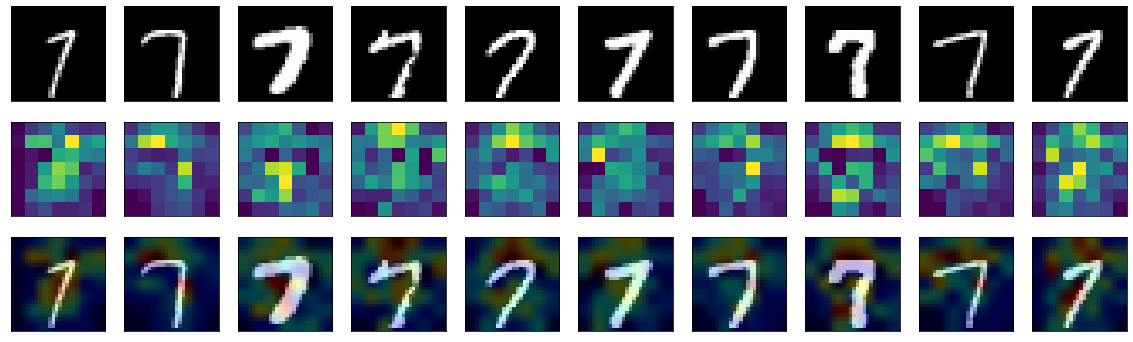

number 8 ->


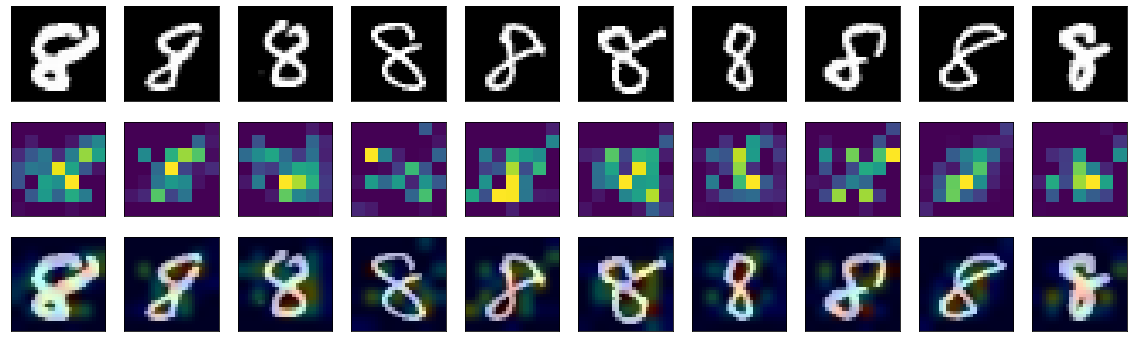

number 9 ->


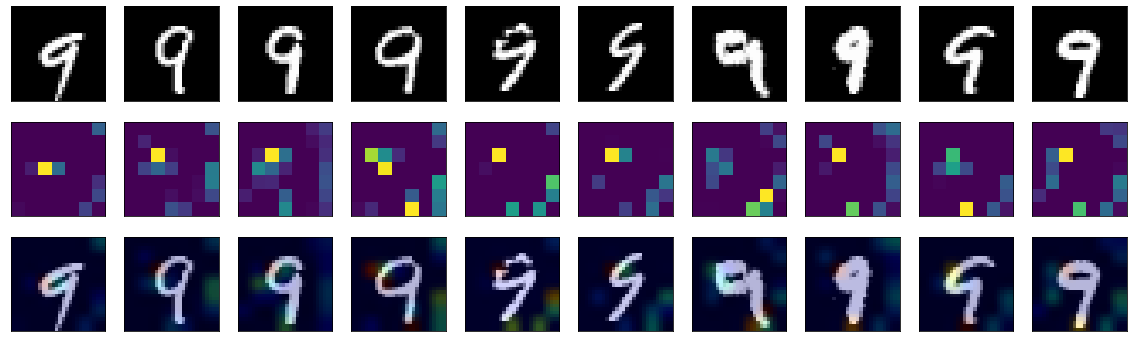

In [ ]:
last_conv_layer_name = "conv2d_2"

for i, images in enumerate(imgs):
    print(f'number {i} ->')
    plt.figure(figsize=(20, 6))
    plt.xticks([])
    plt.yticks([])
    for j, img_array in enumerate(images):
        heatmap = make_gradcam_heatmap(
            np.expand_dims(img_array, axis=0), model, last_conv_layer_name
        )
        
        superimposed = create_superimposed(img_array, heatmap)

        plt.subplot(3, 10, j+1, xticks=([]), yticks=([]))
        plt.imshow(np.squeeze(img_array, axis=2), cmap='gray')

        plt.subplot(3, 10, 10+j+1, xticks=([]), yticks=([]))
        plt.imshow(heatmap)

        plt.subplot(3, 10, 20+j+1, xticks=([]), yticks=([]))
        plt.imshow(superimposed)
    
    plt.show()
